# HAI DataSet Baseline Model

본 문서는 HAICon을 위한 베이스라인 모델을 제공합니다.

Recurrent neural network(RNN)을 이용했으며 구현 시 라이브러리는 PyTorch를 이용했습니다.

GPU가 1개 있다고 가정하고 코드가 작성되었습니다.
CPU로만 구동해보실 경우에는 모델과 batch feed 코드에서 .cuda()를 호출하지 않으시면 됩니다.

구현 편의성을 위해 전역 변수가 많이 사용되었습니다.
양해 바랍니다.
전역 변수는 모두 대문자로 명명했습니다.

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [2]:
TRAIN_DATASET = sorted([x for x in Path("../../HAICon2021_dataset/train/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('../../HAICon2021_dataset/train/train1.csv'),
 PosixPath('../../HAICon2021_dataset/train/train2.csv'),
 PosixPath('../../HAICon2021_dataset/train/train3.csv'),
 PosixPath('../../HAICon2021_dataset/train/train4.csv'),
 PosixPath('../../HAICon2021_dataset/train/train5.csv'),
 PosixPath('../../HAICon2021_dataset/train/train6.csv')]

In [3]:
TEST_DATASET = sorted([x for x in Path("../../HAICon2021_dataset/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('../../HAICon2021_dataset/test/test1.csv'),
 PosixPath('../../HAICon2021_dataset/test/test2.csv'),
 PosixPath('../../HAICon2021_dataset/test/test3.csv')]

In [4]:
VALIDATION_DATASET = sorted([x for x in Path("../../HAICon2021_dataset/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('../../HAICon2021_dataset/validation/validation.csv')]

In [5]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW는 각각 학습 데이터를 하나의 Pandas Dataframe으로 로드한 결과입니다.
각 필드가 가지는 값의 범위는 크게 다릅니다.
정규화가 필요합니다.

In [6]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


학습 데이터셋은 공격을 받지 않은 평상시 데이터이고 시간을 나타내는 필드인 time이 있으며, 나머지 필드는 모두 비식별화된 센서/액추에이터의 값입니다.
정규화는 센서/액추에이터 필드만을 대상으로 해야 합니다.

본 문서에서는 전체 데이터를 대상으로 이상을 탐지하므로 "attack" 필드만 사용하였습니다.

VALID_COLUMNS_IN_TRAIN_DATASET은 학습 데이터셋에 있는 모든 센서/액추에이터 필드를 담고 있습니다.
가끔 학습 데이터셋에 존재하지 않는 필드가 테스트 데이터셋에 존재하는 경우가 있습니다.
학습 시 보지 못했던 필드에 대해서 테스트를 할 수 없으므로 학습 데이터셋을 기준으로 필드 이름을 얻어냈습니다.

In [7]:
TRAIN_DF_RAW.head()

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


In [8]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

TAG_MIN과 TAG_MAX는 학습 데이터셋에서 최솟값 최댓값을 얻은 결과입니다.

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

print(f'TAG_MIN : \n{TAG_MIN}')
print('----------------')
print(f'TAG_MAX : \n{TAG_MAX}')

TAG_MIN : 
C01     -4.62710
C02      0.00000
C03     11.98730
C04     -0.04253
C05      0.26855
         ...    
C82      1.00000
C83    890.04523
C84     12.00000
C85     50.00000
C86   -112.00000
Length: 86, dtype: float64
----------------
TAG_MAX : 
C01        0.82860
C02        0.00000
C03       16.86249
C04        0.04051
C05      100.87737
          ...     
C82        1.00000
C83     1121.85547
C84       17.14934
C85       50.00000
C86    12993.00000
Length: 86, dtype: float64


normalize 함수는 Dataframe을 정규화합니다.
정규화 방법은 최솟값, 최댓값을 이용하여 0~1의 범위에 들어오도록 하는 것입니다.

가끔 값이 전혀 변하지 않는 필드가 있습니다.
이 경우 최솟값과 최댓값이 같을 것입니다.
본 문서에서는 이런 필드를 모두 0으로 만들었습니다.

In [10]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

TRAIN_DF는 정규화를 마친 후 exponential weighted function을 통과시킨 결과입니다.
센서에서 발생하는 noise를 smoothing 시켜주기를 기대하고 적용했습니다.

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


boundary_check 함수는 Pandas Dataframe에 있는 값 중 1 초과의 값이 있는지, 0 미만의 값이 있는지, NaN이 있는지 점검합니다.

In [12]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [13]:
boundary_check(TRAIN_DF)

(False, False, False)

1보다 큰 값, 0보다 작은 값, not a number가 없습니다. 정규화가 정상적으로 처리되었습니다.

## 학습 모델 설정 & 데이터 입출력 정의

딥러닝 학습과 추론에는 PyTorch를 사용했습니다.

베이스라인 모델은 Stacked RNN(GRU cells)을 이용해서 이상을 탐지합니다.
정상 데이터만 학습해야 하고, 정상 데이터에는 어떠한 label도 없으므로 unsupervised learning을 해야 합니다.

본 모델에서는 슬라이딩 윈도우를 통해 시계열 데이터의 일부를 가져와서 해당 윈도우의 패턴을 기억하도록 했습니다.
슬라이딩 윈도우는 90초(HAI는 1초마다 샘플링되어 있습니다)로 설정했습니다.

모델의 입출력은 다음과 같이 설정했습니다.
- 입력 : 윈도우의 앞부분 89초에 해당하는 값
- 출력 : 윈도우의 가장 마지막 초(90번째 초)의 값

이후 탐지 시에는 모델이 출력하는 값(예측값)과 실제로 들어온 값의 차를 보고 차이가 크면 이상으로 간주했습니다.
많은 오차가 발생한다는 것은 기존에 학습 데이터셋에서 본 적이 없는 패턴이기 때문이라는 가정입니다.

In [14]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L])
            == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
                
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        
        print(f"# of valid windows: {self.n_idxs}")
        
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

HaiDataset 클래스는 PyTorch의 Dataset 인터페이스를 정의한 것입니다.

데이터셋을 읽을 때는 슬라이딩 윈도우가 유효한 지 점검합니다.
정상적인 윈도우라면 원도우의 첫 시각과 마지막 시각의 차가 89초가 되어야 합니다.

stride 파라미터는 슬라이딩을 할 때 크기를 의미합니다.
전체 윈도우를 모두 학습할 수도 있지만, 시계열 데이터에서는 슬라이딩 윈도우를 1초씩 적용하면 이전 윈도우와 다음 윈도우의 값이 거의 같습니다.
본 노트북에서는 학습을 빠르게 마치기 위해 10초씩 건너뛰면서 데이터를 추출하도록 했습니다.
(물론 슬라이딩 크기를 1로 설정하여 모든 데이터셋을 보게 하면 더 좋을 것입니다)

In [16]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]


# of valid windows: 1003868


{'ts': '2021-07-11 10:01:29',
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3205, 0.0000, 0.0548,  ..., 0.0000, 0.0000, 0.0091],
         [0.4451, 0.0000, 0.0562,  ..., 0.0000, 0.0000, 0.0091],
         [0.3477, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3711, 0.0000, 0.0563, 0.5032, 0.1387, 0.4298, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7223, 0.6224, 0.4866, 0.4075, 0.2524, 0.2907, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4108, 0.0000, 0.3492, 0.6516, 0.0120, 0.0000, 0.3563,
         0.3370, 0.0000, 0.9763, 0.5501, 0.3796, 0.3818, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0249, 0.2642, 0.5416, 0.5994, 0.4009, 0.0021,
         1.0000, 0.5253, 1.0000, 0.0000, 0.2244, 0.4755, 0.0000, 0.4874, 0.0509,
         0.0000, 0.3105, 0.7985, 0.1781, 0.2572, 0.4340, 1.

데이터셋이 잘 로드되는 것을 볼 수 있습니다.

모델은 3층 bidirectional GRU를 사용합니다.
Hidden cell의 크기는 100으로 설정했습니다.
Dropout은 사용하지 않았습니다.

모델이 윈도우의 가장 첫 번째 값과 RNN의 출력을 더해서 내보내도록 skip connection(forward 메소드의 return 문 참조)을 만들었습니다.

In [18]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [19]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(86, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=86, bias=True)
)

## 신규 모델 학습

모델 학습을 직접 하려면 아래 코드를 실행하시면 됩니다.

이미 학습된 모델을 로드해서 결과만 보시려면 아래 '모델 불러오기' section으로 가셔서 실행을 이어가시면 됩니다.

Loss function은 MSE를 선택했고, optimizer는 AdamW(Loshchilov & Hutter, "Decoupled Weight Decay Regularization", ICLR 2019)를 사용합니다.

학습 시 epoch loss가 가장 좋았던 모델의 파라미터를 저장합니다.

In [18]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

학습은 32 에포크 진행했습니다. (-> 50)

In [19]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 50)


CPU times: user 1h 28min 43s, sys: 13.8 s, total: 1h 28min 57s
Wall time: 1h 28min 55s


In [20]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.266398190142354, 40)

In [21]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

## 모델 불러오기

이미 학습된 모델 파라미터와 training loss 기록을 불러옵니다.

In [20]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

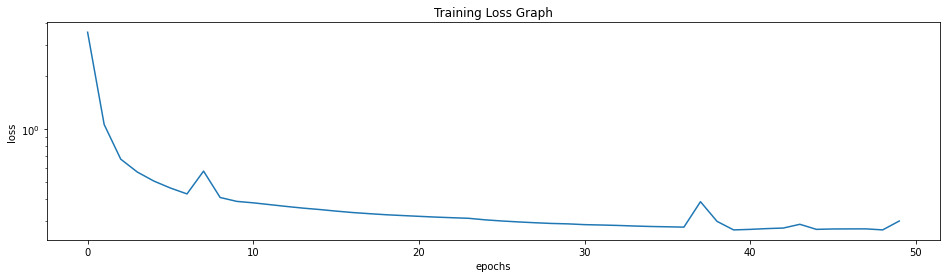

In [21]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

## 학습된 모델을 이용한 탐지

검증 데이터셋을 불러와서 모델에 입력으로 주고 예측값과 실제값의 차를 얻어봅니다.

검증 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해봅니다.
Not a number가 있는지 점검하는 것이 주요 목적입니다.

In [22]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


검증 데이터셋도 정상 데이터셋의 최솟값, 최댓값을 이용해서 정규화합니다.

In [23]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [24]:
boundary_check(VALIDATION_DF)

(True, True, False)

공격 데이터셋에서는 확실히 정상 데이터의 최솟값과 최댓값을 벗어나는 값이 나타나고 있습니다.

In [25]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 86311


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4517,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3819,  0.0000, -0.0421,  ...,  0.0000,  0.0000,  0.0200],
         ...,
         [ 0.4541,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4627,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4740,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.3894e-01,  0.0000e+00, -4.0688e-02,  5.5241e-01,  1.4881e-01,
          4.1252e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0504e-01,  5.4733e-01,  4.3329e-01,  5.1462e-01,  3.9176e-01,
          2.2703e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3473e-01,  2.6757e-01,  1.0783e-01,
          0.0000e+00,  4.3937e-01,  3.6840e-01,  0.0000e+00,  9.9556e-01,
          5.8627e-01,  2.9203e-01,  2.2335e-01,  

In [27]:
len(HAI_DATASET_VALIDATION)

86311

검증 데이터셋에 대해서도 PyTorch Dataset 인스턴스를 만들었습니다.
모든 데이터 포인트에 대해 점검해야 하므로 학습 데이터 때와는 다르게 슬라이딩의 크기는 1로 두어야 합니다.

In [28]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

In [30]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

KeyboardInterrupt: 

In [31]:
print(len(CHECK_TS))
print(len(CHECK_DIST))
print(len(CHECK_ATT))

NameError: name 'CHECK_TS' is not defined

CHECK_DIST는 검증 데이터셋 전체 시간대에 대해 모든 필드의 |예측값 - 실제값|을 가지고 있습니다.

In [30]:
type(CHECK_DIST)

numpy.ndarray

In [31]:
CHECK_DIST.shape

(86311, 86)

공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계산합니다.

In [32]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [33]:
ANOMALY_SCORE.shape

(86311,)

In [34]:
ANOMALY_SCORE

array([0.01225824, 0.01615411, 0.01568966, ..., 0.01230022, 0.01183835,
       0.01228593], dtype=float32)

결과를 눈으로 확인하기 위해 그래프를 그려보겠습니다.
piece 파라미터는 그래프를 몇 개로 나누어 그릴지를 결정합니다.
세세한 결과를 보고 싶을 경우 숫자를 늘리면 됩니다.

In [35]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

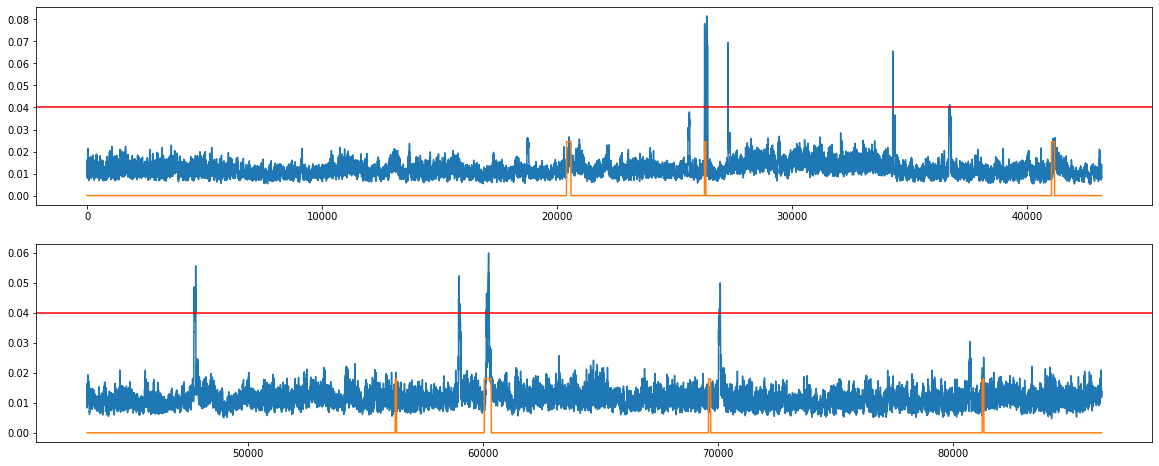

In [36]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다.
전반적으로 공격 위치에서 큰 오차를 보이고 있습니다.

임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다.
공격은 1로 정상은 0으로 표기합니다.

In [34]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다.
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.

In [35]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86311,))

정답지(ATTACK_LABELS)도 동일하게 추출합니다.
검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다.
위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [36]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

탐지 모델이 윈도우 방식으로 판단을 진행했기 때문에,
1. 첫 시작의 몇 초는 판단을 내릴 수 없고
2. 데이터셋 중간에 시간이 연속되지 않는 구간에 대해서는 판단을 내릴 수 없습니다.

위에서 보시는 바와 같이 정답에 비해 얻어낸 label의 수가 적습니다.

아래의 fill_blank 함수는 빈칸을 채워줍니다.
빈 곳은 정상(0) 표기하고 나머지는 모델의 판단(정상 0, 비정상 1)을 채워줍니다.

In [37]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [38]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 12.4 s, sys: 0 ns, total: 12.4 s
Wall time: 12.4 s


(86400,)

## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [39]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

TaPR 점수를 받습니다.

In [40]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.049 (TaP: 0.075, TaR: 0.036)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe0ebb415c0>]


In [41]:
import numpy as np

best_thres = 0
best_f1 = 0

for THRESHOLD in list(np.around(np.arange(0.030, 0.050, 0.001),3)):
    print(f'----------THRESHOLD : {THRESHOLD}----------')
    LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
    print('>>> LABELS')
    print(LABELS, LABELS.shape)
    FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
    print('>>> FINAL_LABELS')
    print(FINAL_LABELS, FINAL_LABELS.shape)
    
    if ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]:
        TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
        print(f">>> F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
        print(f">>> # of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
        print(f">>> Detected anomalies: {TaPR['Detected_Anomalies']}")
        
        if TaPR['f1']>=best_f1:
              best_thres = THRESHOLD
              best_f1 = TaPR['f1']
              print("***Best Threshold updated!!***")

----------THRESHOLD : 0.03----------
>>> LABELS
[0. 0. 0. ... 0. 0. 0.] (86311,)
>>> FINAL_LABELS
[0 0 0 ... 0 0 0] (86400,)
>>> F1: 0.119 (TaP: 0.100, TaR: 0.147)
>>> # of detected anomalies: 2
>>> Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe0eba4c208>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe0eba4c748>]
***Best Threshold updated!!***
----------THRESHOLD : 0.031----------
>>> LABELS
[0. 0. 0. ... 0. 0. 0.] (86311,)
>>> FINAL_LABELS
[0 0 0 ... 0 0 0] (86400,)
>>> F1: 0.094 (TaP: 0.073, TaR: 0.134)
>>> # of detected anomalies: 2
>>> Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe0eba4cc88>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe0eba4c588>]
----------THRESHOLD : 0.032----------
>>> LABELS
[0. 0. 0. ... 0. 0. 0.] (86311,)
>>> FINAL_LABELS
[0 0 0 ... 0 0 0] (86400,)
>>> F1: 0.087 (TaP: 0.077, TaR: 0.101)
>>> # of detected anomalies: 1
>>> Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe1182b9588>]
-------

In [42]:
best_thres

0.03

In [43]:
best_f1

0.1186994118674989

In [44]:
THRESHOLD = best_thres

## 테스트 데이터셋 예측
학습 데이터셋과 검증 데이터셋을 이용해 만든 모델로 테스트 데이터셋 결과를 예측합니다.

In [45]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


테스트 데이터셋도 정상 데이터셋의 최솟값, 최댓값을 이용해서 정규화합니다.

In [46]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


테스트 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해봅니다.
Not a number가 있는지 점검하는 것이 주요 목적입니다.

In [47]:
boundary_check(TEST_DF)

(True, True, False)

In [48]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 274533


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4517,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3819,  0.0000, -0.0421,  ...,  0.0000,  0.0000,  0.0200],
         ...,
         [ 0.4541,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4627,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4740,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.3894e-01,  0.0000e+00, -4.0688e-02,  5.5241e-01,  1.4881e-01,
          4.1252e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0504e-01,  5.4733e-01,  4.3329e-01,  5.1462e-01,  3.9176e-01,
          2.2703e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3473e-01,  2.6757e-01,  1.0783e-01,
          0.0000e+00,  4.3937e-01,  3.6840e-01,  0.0000e+00,  9.9556e-01,
          5.8627e-01,  2.9203e-01,  2.2335e-01,  

테스트 데이터셋에 대해서도 PyTorch Dataset 인스턴스를 만들었습니다. 모든 데이터 포인트에 대해 점검해야 하므로 검증 데이터 때와 마찬가지로 슬라이딩의 크기는 1로 두어야 합니다.

inference 함수로 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

In [49]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 12.7 s, sys: 88 ms, total: 12.8 s
Wall time: 12.8 s


공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계산합니다.

In [50]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

결과를 눈으로 확인하기 위해 그래프를 그려보겠습니다.

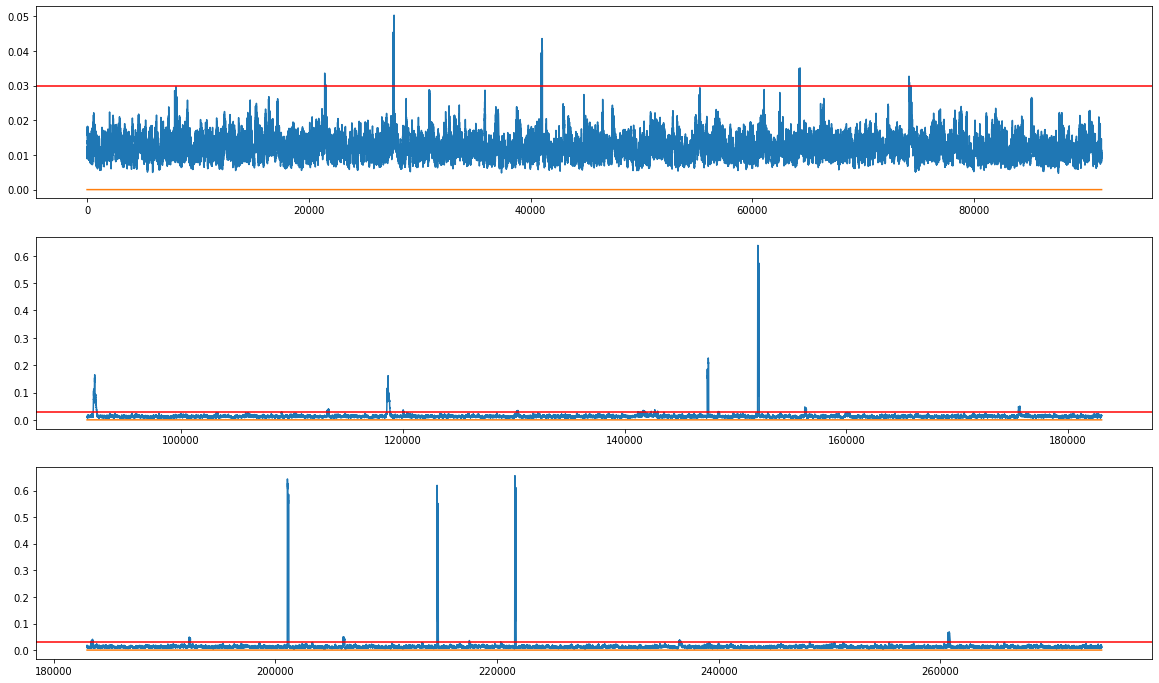

In [51]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

검증 데이터셋을 이용해 찾은 threshold를 이용해 공격 여부를 예측합니다.

In [52]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (274533,))

예측한 결과를 제출양식에 맞춰 저장합니다.

In [54]:
submission = pd.read_csv('../../HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [55]:
submission['attack'].value_counts()

0.0    272496
1.0      2304
Name: attack, dtype: int64

예측한 결과를 저장하여 제출합니다.

In [56]:
submission.to_csv(f'baseline_efm_thres{THRESHOLD}.csv', index=False)

---
**Copyright 2020. ETRI부설국가보안기술연구소. All rights reserved.**